In [ ]:
#hide
from nbdev import *
from utilities.ipynb_docgen import *

# Making FermiLAT gamma-ray Light curves with wtlike 

> Quickly create a light curve for any 4FGL source, on any time scale, with optional Bayesian Block analysis 

#### github links:  
[this document](https://tburnett.github.io/wtlike/),   [the repository](https://github.com/tburnett/wtlike)

## Introduction
`wtlike`(Perhaps pronounced "DUB-Tee-like"), is a library optimized for interactive exploration in a [Jupyter notebook](https://jupyter.org/) with access to all Fermi-LAT data, and to analyze the time dependence of any source in the
4FGL catalog on any time scale, with the option of performing a [Bayesian Block](https://arxiv.org/pdf/1207.5578.pdf)  partition to select optimal time intervals. The source can be identified by the 4FGL name, or any equivalent common name.

Here is a minimal demo:

SourceData:  3C 273: Restoring from cache with key "P88Y3157_data"
SourceData: Source 3C 273 with:
	 data:        96,186 photons from 2008-08-04 to 2021-08-01
	 exposure: 2,872,539 intervals,  average flux 1989 cm^2 for 85.8 Ms
	 rates:  source 1.73e-07/s, background 3.91e-07/s, S/N ratio 4.42e-01
CellData: Bin photon data into 677 1-week bins from 54683.0 to 59422.0
LightCurve: select 667 cells for fitting with e>5 & n>2


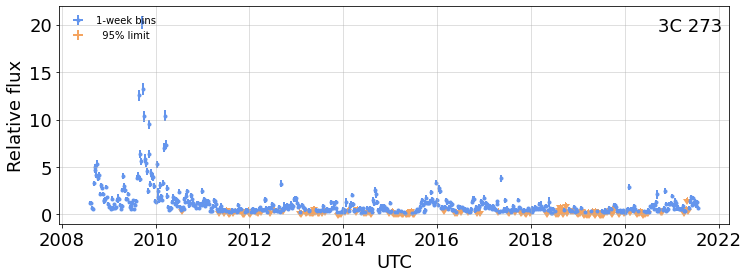

In [ ]:
from wtlike import *
config = Config()
if config.valid:
    wtl = WtLike('3C 273')
    wtl.plot(UTC=True);

This assumes that the name for the source, in this case the historically famous first [quasar](https://en.wikipedia.org/wiki/Quasar#Background) to be discovered, can be associated with a 4FGL catalog source. The plot shows, as a function of UTC (or MJD if desired) time, weekly measurements of deviations of the flux relative to the average of the 12-year interval used to define the 4FGL-DR3 catalog.

The first stage, extracting data for the source, takes ~10 min, but, using an included [cache system](https://tburnett.github.io/wtlike/config.html#Cache), only has to be done once.

## Overview

This package has code that was developed with the [nbdev](https://nbdev.fast.ai/) code/tests/documentation environment from the [github package lat-timing](https://github.com/tburnett/lat-timing) to generate light curves of Fermi-LAT sources.  
It is based on a [paper](https://arxiv.org/pdf/1910.00140.pdf) by Matthew Kerr, which derives the [weighted likelihood formalism](https://tburnett.github.io/wtlike/loglike#The-Kerr-likelihood-formula) used here, specifically with
the [Bayesian Block](https://arxiv.org/pdf/1207.5578.pdf) to detect and characterize variability of a gamma-ray source.

There are several innovative design features that significantly improve the speed and portability.

* Condensed photon and spacecraft data. 
* Weight tables
* A cache to improve interactivity
* Likelihood functions fit to a modified Poisson function
* Unbinned likelihood 
* A simple user interface


### How it works

Historically, gamma-ray source measurements have used two methods:
1. For a fixed time interval, where the energy and 
position are used, with a model including all potential sources and a model of the detector response to 
define the likelihood. This has been the only way to study weak sources. A light curve must apply this to
each time interval.
2. Or, for very bright flares, for example GRBs, one can simply count the number of photons within a
circular region, that is, aperture photometry.

Matthew Kerr [introduced](https://arxiv.org/pdf/1910.00140.pdf) a third method, basically counting photons but using information from a static
likelihood analysis to assign a "weight" to each photon, the probability for being from the source in question, then optimizing this likelihood. This assumes that the only thing changing is the flux of
the source.  He calls it "retrospective", since the analysis for the full time is then applied back to the individual photons.

### Individual photon Likelihood ("unbinned")
We use  a version of the Kerr likelihood where the fundamental "cell" is a single photon. The likelihood for any group of photons 
is easily determined by adding the photons.

Assumptions:
* Source photons are completely contained in the dataset boundaries (the "ROI").
* The instrument response is constant with time.
* The background pattern is constant. (Clearly violated if a neighboring source varies!)

For a photon $i$ with weight $w_i$ and exposure $\tau_i$,

$$ \displaystyle\log\mathcal{L}_i(\alpha) = \log (1 + \alpha \ w_i ) - \alpha \ w_i\ R\ \tau_i $$

where:
* $\alpha$ -- fractional deviation of the source flux from the average as measured by the catalog analysis 
* $w_i$ -- probability, for the nominal source rate, that photon $i$ is from the source.
* $R$ -- expected source rate in $\mathrm{cm^{-2}\ s^{-1}}$ units. 
* $\tau_i$ -- integration of the exposure rate for the live time preceding this detection in $\mathrm{cm^2} s$ units. 
Live time, the time since the start of a run, or the previous photon. It is equivalent to time.  
This behaves like a time, but accounts for variation of the exposure rate, often rapid with respect to event rates.

(A note about "exposure": It has units $\mathrm{cm^2\ s}$ and is the integral of the "exposure rate" over a time interval.
For *Fermi*, the rate is the effective area, typically $\mathrm{3000 cm^2}$ but varies as much as a factor of three over a single orbit.)

This is evaluated in the module  [loglike](https://tburnett.github.io/wtlike/loglike).

### Photon Data

*Fermi* data are retrieved from the Fermi-LAT weekly data files extracted from the [GSFC FTP server](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly), 
with subfolders for the photon data, `photon` and spacecraft data, `spacecraft`. It is [described here](http://fermi.gsfc.nasa.gov/ssc/data/access/http://fermi.gsfc.nasa.gov/ssc/data/access/). The files are organized into individual weeks, starting UTC midnight each Thursday. Files for the most recent week are updated daily.

We convert each pair of photon and spacecraft files to two DataFrame tables with the minimum information needed to evaluate the likelihood, as compressed as possible. Particularly, the energy and position are binned. Details can be seen in the module [data_man](https://tburnett.github.io/wtlike/data_man).  

The entire data set in this format occupies <2 GB.

### Select Data for a source

All further processing uses a subset of the photons within a cone, currently $4^\circ$, about the selected source, and 
evaluates the exposure during 30-s intervals for this direction.  In the class
[`SourceData`](https://tburnett.github.io/wtlike/source_data#SourceData), implemented in the module 
[`source_data`](https://tburnett.github.io/wtlike/source_data) we
1. Extract photons
2. Evaluate exposure, using the effective area tables and a spectral assumption.
3. Determine the weight for each photon, using the table for the source. See the module [weights](https://tburnett.github.io/wtlike/weights) for details.
4. For each photon's livetime, determine the exposure $\tau$. 

The result is a photon DataFrame, containing for each photon, the time $t$ in MJD units, $w$,  and $\tau$.

This class is a superclass of the user interface class `WtLike` introduced above.

### Partition into cells

A "cell", the terminology used by Kerr, the set of photons in a specific time interval. The class 
[CellData](https://tburnett.github.io/wtlike/cell_data#CellData)
in the module [cell_data](https://tburnett.github.io/wtlike/cell_data), a subclass of SourceData manages this.

This class is instantiated with a tuple to define the binning in time. Denoted by `(a, b, c)`, the elements are:
* `a`--start time 
* `b`--stop time
* `c`-- bin size in days, but 0 means orbit-based, intervals are contiguous eposure.

For the start and stop, values > 50000 are interpreted as MJD. Otherwise they are relative to start if positive
or stop if negative for the full dataset, both rounded to a full day. Zero means actual start for `a` and stop for `b`.
The default binning is simply `(0, 0, 7)` for weekly bins with the full dataset. Hourly for the most recent week would be `(-7, 0, 1/24)`.

A DataFrame table of the cells is created as a data member `cells`, with content

* `t` -- MJD time at cell center
* `tw` -- cell width in days
* `e` -- cell exposure, for reference 
* `n` -- the number of photons
* `w` -- a list of `n` weights
* `S` -- expected number source photons, the nominal source rate times the sum of $\tau$ values.
* `B` -- expected number of background photons (unused)

### Views

`CellData` implements a method `view`, which accepts a binning tuple as an argument, returns a *copy* of the current object, which can be a subclass, assigning to it the binning. Thus the view has all the attributes of its parent, but
with a different set of cells. 

So the following creates a new WtLike object that we generated above, rebins a copy with 25-day bins in the first 100 days, generates a list of the cells, then removes it since it wasn't assigned a reference variable.


In [ ]:
if config.valid:
    wtl.view(0,100,25).cells

CellData: Bin photon data into 4 4-week bins from 54683.0 to 54783.0
LightCurve: select 4 cells for fitting with e>5 & n>2


,t,tw,e,n,w,S,B
0,54695.5,25.0,1076.90,553,"[0.489013671875, 0.806640625, 0.113037109375, ...",185.90,421.04
1,54720.5,25.0,1353.24,1438,"[0.4345703125, 0.6064453125, 0.069091796875, 0...",233.60,529.08
2,54745.5,25.0,1049.03,1183,"[0.339111328125, 0.31005859375, 0.708984375, 0...",181.09,410.14
3,54770.5,25.0,1396.37,1175,"[0.09112548828125, 0.58251953125, 0.0753784179...",241.05,545.94


### Evaluate Likelihoods and make light curve plots

The class [`LightCurve`](https://tburnett.github.io/wtlike/lightcurve), implemented in the module [`lightcurve`](https://tburnett.github.io/wtlike#LightCurve) is a subclass of `SourceData`.
An instance invokes its superclass to generate the set of cells, then evaluates the likelihoods.

#### Poisson-like Likelihood
We fit the likelihood for each cell, using only a few evaluations, to a [3-parameter Poisson-like formula](https://tburnett.github.io/poisson). Two advantages of this are:
* efficiency -- for large numbers of photons, this is much faster
* convenience -- the [`Poisson`](https://tburnett.github.io/wtlike/poisson.html#Poisson) object implements functions that return the TS, 95% CL, maximum, and uncertainties, using the [incomplete gamma function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html).

This results in a DataFrame `fits` containing
* `t, tw, n`, from the cell, and
* `fit`, the `Poisson` object

#### Light curve plots

The function `Likelihood.plot` actually invokes [`flux_plot`](https://tburnett.github.io/lightcurve#flux_plot)

### Apply Bayesian Blocks
The class [`WtLike`](https://tburnett.github.io/wtlike/90-main.html#WtLike), 
implememted in the module [`main`](https://tburnett.github.io/wtlike/90-main.html), adds an implementation of the Bayesian Block (BB) algorithm, from the module [`bayesian`](https://tburnett.github.io/wtlike)  using likelihood instead of counts.
There we have two subclasses of `astropy.stats.bayesian_blocks`, [`CountFitness`](https://tburnett.github.io/wtlike/bayesian.html#CountFitness) and the default [`LikelihoodFitness`](https://tburnett.github.io/wtlike/bayesian.html#LikelihoodFitness).
    
This code creates partitions between boundaries of a set of cells. Usage is via a special view, 
[bb_view`](https://tburnett.github.io/wtlike/main#WtLike.bb_view)
                     

LightCurve: select 667 cells for fitting with e>5 & n>2
Bayesian Blocks: using penalty 0.05
	Partitioned 667 cells into 93 blocks, using LikelihoodFitness 
LightCurve: Loaded 93 / 93 cells for fitting


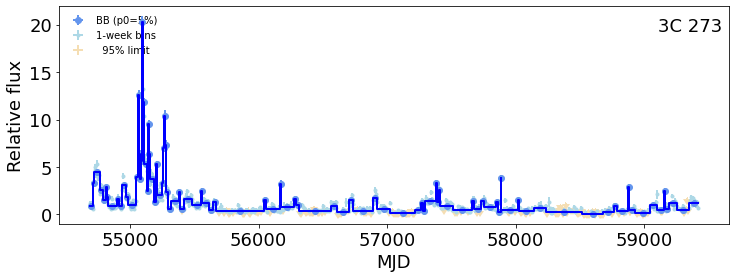

In [ ]:
if config.valid:
    bb = wtl.bb_view()
    bb.plot();

As you see, this made 94 blocks from the 656 weeks, fit each, and overplotted in on the weekly light curve.

### Simulation

Finally, a simulation option is available. See the [tutorial](https://tburnett.github.io/wtlike/tutorial/)  for an example

## Installation

Note that this is in beta mode. 
It requires:  matplotlib pandas scipy astropy healpy

To install from pyPI:

```
pip install wtlike
```
Data requirements: There are three sets of files:

- **photon data**<br> 
These are a set of weekly pickled python `dict` objects with compressed condensed photon and spacecraft data extracted from the GSFC FTP site. They contain every photon above 100 MeV, and less than $100^\circ$ 
from the zenith.

- **weight tables**<br>
Each source to be analyzed needs a table defining the photon weight as a function of position, energy, and event type. These are currently generated by pointlike. (A `fermipy`-generated version would be preferable.)

- **effective area**<br>
A standard *Fermi* instrument response file (IRF) defining the effective area as a function of detector angle and energy. 

A set of these is available as a 1.6 GB zip file.

## Input data

There are three data sources which `wtlike` needs to function:


-	The photon/spacecraft data
-	A table of weights for each source
-	An effective area IRF table 

These must be found under a folder, which by default is `~/wtlike_data`. In that folder there must be (perhaps links to) three folders named `data_files`, `weight_files`, `aeff_files`.  A copy of what I'm using is at `/afs/slac/g/glast/users/burnett/wtlike_data`